In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

2024-03-13 14:56:11.598673: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-13 14:56:11.792174: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 14:56:11.792198: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 14:56:11.792753: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 14:56:11.868560: I tensorflow/core/platform/cpu_feature_g

In [2]:
batch_size = 64
img_height = 227
img_width = 227
data_dir = 'dataset_v2'

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16873 files belonging to 8 classes.
Using 13499 files for training.


2024-03-13 14:56:17.034430: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 14:56:17.055418: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 14:56:17.055446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 14:56:17.057314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-13 14:56:17.057342: I tensorflow/compile

In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 16873 files belonging to 8 classes.
Using 3374 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']


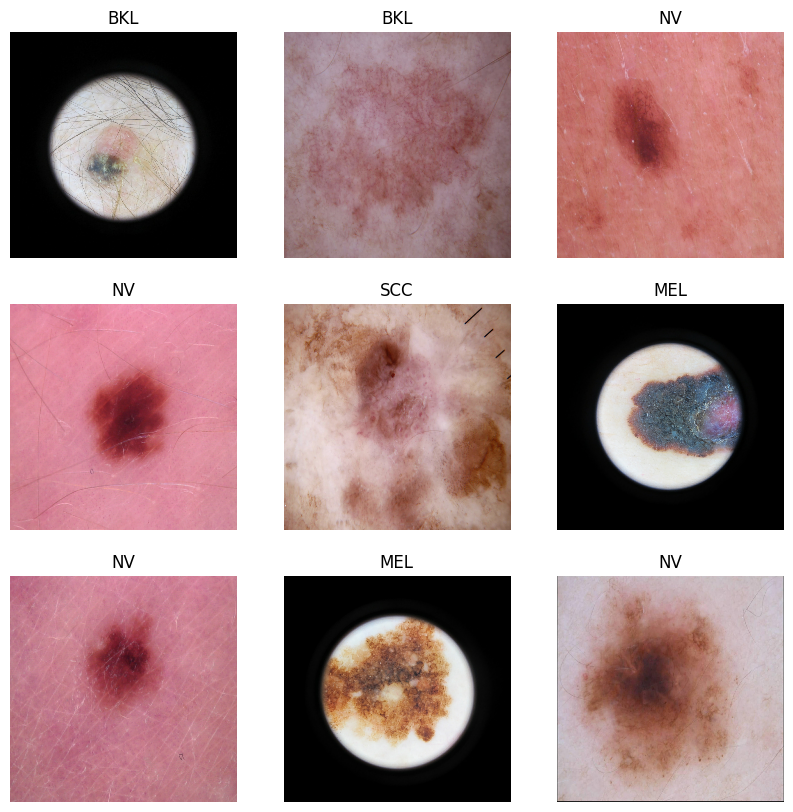

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [8]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.9498635


In [10]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
num_classes = 8

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [10]:
def alex_net_model(input_shape = (227,227,3)):
    model = tf.keras.Sequential([
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4096, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(8, activation='softmax')
    ])
    
    return model

In [11]:
model = alex_net_model()
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [12]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=80
)

Epoch 1/80


2024-03-13 14:56:48.656546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-03-13 14:56:50.048162: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1fac03a760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-13 14:56:50.048190: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-13 14:56:50.054224: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-13 14:56:50.138703: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


211/211 [==============================] - 22s 76ms/step - loss: 3.4320 - accuracy: 0.4016 - val_loss: 1.5037 - val_accuracy: 0.4597
Epoch 2/80
211/211 [==============================] - 14s 66ms/step - loss: 1.5105 - accuracy: 0.4634 - val_loss: 1.5510 - val_accuracy: 0.3729
Epoch 3/80
211/211 [==============================] - 15s 67ms/step - loss: 1.4547 - accuracy: 0.4830 - val_loss: 1.4892 - val_accuracy: 0.4535
Epoch 4/80
211/211 [==============================] - 14s 66ms/step - loss: 1.4443 - accuracy: 0.4878 - val_loss: 1.5190 - val_accuracy: 0.4475
Epoch 5/80
211/211 [==============================] - 15s 69ms/step - loss: 1.4315 - accuracy: 0.4954 - val_loss: 1.4958 - val_accuracy: 0.4615
Epoch 6/80
211/211 [==============================] - 15s 68ms/step - loss: 1.4266 - accuracy: 0.5009 - val_loss: 1.7644 - val_accuracy: 0.3755
Epoch 7/80
211/211 [==============================] - 15s 67ms/step - loss: 1.3995 - accuracy: 0.5120 - val_loss: 1.4730 - val_accuracy: 0.4659
Epo

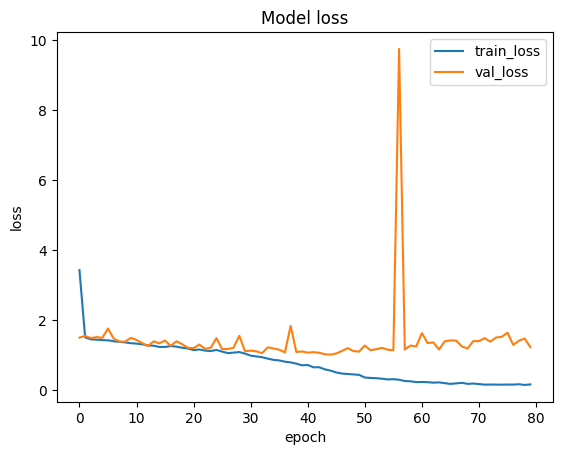

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])

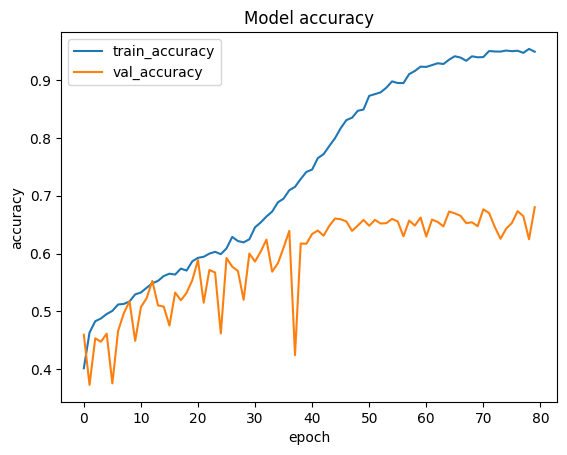

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])

In [17]:
model.save("alex_v2")

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(11, 11, 3, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1ffefa4650>, 139774783523776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(11, 11, 3, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1ffefa4650>, 139774783523776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f202011c350>, 139774783563424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f202011c350>, 139774783563424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda4c82d0>, 139774783606976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda4c82d0>, 139774783606976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda355c90>, 139774783606896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda355c90>, 139774783606896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda37fdd0>, 139774783641744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda37fdd0>, 139774783641744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda3adc50>, 139774783641824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda3adc50>, 139774783641824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda3dfc10>, 139774783522416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda3dfc10>, 139774783522416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ec9b50>, 139774783535696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ec9b50>, 139774783535696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ef3c10>, 139774783637664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ef3c10>, 139774783637664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f21a90>, 139774783645904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f21a90>, 139774783645904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f53ad0>, 139774783649264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f53ad0>, 139774783649264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f79c50>, 139774783649104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f79c50>, 139774783649104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9fa3cd0>, 139774783647984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9fa3cd0>, 139774783647984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ddde10>, 139774783646944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ddde10>, 139774783646944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e03f10>, 139774783787280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e03f10>, 139774783787280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e360d0>, 139774783787120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e360d0>, 139774783787120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e70110>, 139774783785440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e70110>, 139774783785440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e93910>, 139774783789040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e93910>, 139774783789040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9cd4110>, 139774783794080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9cd4110>, 139774783794080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9cf62d0>, 139774783793920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9cf62d0>, 139774783793920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9216, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d30150>, 139774783798880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9216, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d30150>, 139774783798880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d62090>, 139774783797920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d62090>, 139774783797920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d83f90>, 139775092543200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d83f90>, 139775092543200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9bb9f90>, 139774783941056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9bb9f90>, 139774783941056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9bdbe50>, 139774783946496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9bdbe50>, 139774783946496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9c15d90>, 139774783946576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9c15d90>, 139774783946576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(11, 11, 3, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1ffefa4650>, 139774783523776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(11, 11, 3, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1ffefa4650>, 139774783523776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f202011c350>, 139774783563424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f202011c350>, 139774783563424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda4c82d0>, 139774783606976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda4c82d0>, 139774783606976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda355c90>, 139774783606896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(96,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda355c90>, 139774783606896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda37fdd0>, 139774783641744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(5, 5, 96, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda37fdd0>, 139774783641744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda3adc50>, 139774783641824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda3adc50>, 139774783641824), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda3dfc10>, 139774783522416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fda3dfc10>, 139774783522416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ec9b50>, 139774783535696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ec9b50>, 139774783535696), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ef3c10>, 139774783637664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 256, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ef3c10>, 139774783637664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f21a90>, 139774783645904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f21a90>, 139774783645904), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f53ad0>, 139774783649264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f53ad0>, 139774783649264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f79c50>, 139774783649104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9f79c50>, 139774783649104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9fa3cd0>, 139774783647984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9fa3cd0>, 139774783647984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ddde10>, 139774783646944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9ddde10>, 139774783646944), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e03f10>, 139774783787280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e03f10>, 139774783787280), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e360d0>, 139774783787120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e360d0>, 139774783787120), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e70110>, 139774783785440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 256), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e70110>, 139774783785440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e93910>, 139774783789040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9e93910>, 139774783789040), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9cd4110>, 139774783794080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9cd4110>, 139774783794080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9cf62d0>, 139774783793920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(256,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9cf62d0>, 139774783793920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9216, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d30150>, 139774783798880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(9216, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d30150>, 139774783798880), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d62090>, 139774783797920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d62090>, 139774783797920), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d83f90>, 139775092543200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 4096), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9d83f90>, 139775092543200), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9bb9f90>, 139774783941056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9bb9f90>, 139774783941056), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9bdbe50>, 139774783946496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(4096, 8), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9bdbe50>, 139774783946496), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9c15d90>, 139774783946576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(8,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f1fd9c15d90>, 139774783946576), {}).


INFO:tensorflow:Assets written to: alex_v2/assets


INFO:tensorflow:Assets written to: alex_v2/assets


In [61]:
from tensorflow.keras import models

In [62]:
reloaded_model = models.load_model('alex_v2')

In [16]:
import cv2
test_image = cv2.resize(cv2.imread("mel.jpg"),  (227,227))

test_image = np.array(test_image).reshape( -1, 227, 227, 3)

prediction = model.predict(test_image)
print(prediction)

1/1 [==============================] - 0s 411ms/step
[[2.8690652e-04 1.4593187e-02 1.7011978e-01 3.7227334e-03 1.5143168e-01
  6.5578467e-01 6.0409529e-04 3.4569949e-03]]
